In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
train_df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
#drop null values
train_df.dropna(inplace=True)
train_df = train_df.sample(30000, random_state = 42)
print(train_df.shape)
train_df.info()

(30000, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 8067 to 125931
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


In [12]:
BERT_VERSION = 'bert-base-uncased'
POOLED_OUTPUT_DIM = 768 
MAX_LEN = 40

In [13]:
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

In [14]:
#train_val split
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [15]:
BS = 128

In [16]:
class BertDataSet:
    def __init__(self, first_questions, second_questions, targets, tokenizer):
        self.first_questions = first_questions
        self.second_questions = second_questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(first_questions)
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        first_question = str(self.first_questions[item])
        second_question = str(self.second_questions[item])

        # removes extra white spaces from questions
        first_question = " ".join(first_question.split())
        second_question = " ".join(second_question.split())
        
        #tokenizing
        inputs = self.tokenizer.encode_plus(
            first_question,
            second_question,
            add_special_tokens=True,
            padding='max_length',
            max_length=2 * MAX_LEN + 3, # max length of 2 questions and 3 special tokens
            truncation=True   
        )
        
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }
        

In [17]:
#creating dataset and return dataloader of it
def get_data_loader(df, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        first_questions=df["question1"].values,
        second_questions=df["question2"].values,
        targets=targets,
        tokenizer=tokenizer
    )
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )
    
    return data_loader

In [18]:

#creating data loaders of train and val data
train_data_loader = get_data_loader(
    df=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=BS,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    df=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4 * BS,
    shuffle=True,
    tokenizer=tokenizer
)

In [20]:
class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask,token_type_ids=token_type_ids)
        
        # add dropout to prevent overfitting.
        pooled = self.dropout(pooled) 
        return self.out(pooled)

model = BertModel(BERT_VERSION).to(device)

In [ ]:
#binary cross entropy loss, sigmoid function
#def loss_fn(outputs, targets):
#    outputs = torch.squeeze(outputs)
#    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)

In [ ]:
#validation loss
#def calculate_loss(data_loader, model, device):
 #   model.eval()
    
    # tells Pytorch not to store values of intermediate computations for backward pass because we not gonna need gradients.
  #  with torch.no_grad():
   #     total_loss = 0
    #    for batch in data_loader:
     #       ids = batch["ids"].to(device, dtype=torch.long)
      #      mask = batch["mask"].to(device, dtype=torch.long)
       #     token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        #    targets = batch["targets"].to(device, dtype=torch.float)

         #   outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
          #  total_loss += loss_fn(outputs, targets).item()
            
#    model.train()

 #   return np.exp(total_loss / len(data_loader))

In [21]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in data_loader:
            ids = batch["ids"]
            mask = batch["mask"]
            token_type_ids = batch["token_type_ids"]
            targets = batch["targets"]
            
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            predictions = nn.Sigmoid()(outputs)
            
            y_true += list(targets.cpu().numpy())
            y_pred += list(predictions.cpu().numpy())
    
    y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return acc, auc

In [22]:
def accuracy(predictions, targets):
    rounded_preds = torch.round(predictions)
    correct = (rounded_preds == targets).float()
    acc = correct.sum() / len(targets)
    return acc

def train_loop(EPOCHS, train_data_loader, val_data_loader, model, optimizer, device, scheduler):
    for epoch in range(EPOCHS):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        model.train()
        for batch in tqdm(train_data_loader):
            ids = batch["ids"]
            mask = batch["mask"]
            token_type_ids = batch["token_type_ids"]
            targets = batch["targets"]
            
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            optimizer.zero_grad()
            
            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = nn.BCEWithLogitsLoss()(outputs, targets.unsqueeze(1))
            acc = accuracy(torch.sigmoid(outputs), targets.unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_acc += acc.item()
        
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_data_loader):
                ids = batch["ids"]
                mask = batch["mask"]
                token_type_ids = batch["token_type_ids"]
                targets = batch["targets"]

                ids = ids.to(device, dtype=torch.long)
                mask = mask.to(device, dtype=torch.long)
                token_type_ids = token_type_ids.to(device, dtype=torch.long)
                targets = targets.to(device, dtype=torch.float)

                outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

                loss = nn.BCEWithLogitsLoss()(outputs, targets.unsqueeze(1))
                acc = accuracy(torch.sigmoid(outputs), targets.unsqueeze(1))

                val_loss += loss.item()
                val_acc += acc.item()

        train_loss /= len(train_data_loader)
        train_acc /= len(train_data_loader)
        val_loss /= len(val_data_loader)
        val_acc /= len(val_data_loader)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.5f}")
        print(f"Val Loss: {val_loss:.5f}, Val Accuracy: {val_acc:.5f}")

In [ ]:
def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    curr_loss = None
    loss = None
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
            #forward pass, saving intermediate computations of the graph for later backprop use.
            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            #backprop.
            loss.backward()
            
            #gradient descent
            optimizer.step()
            
            #loss in every 100 iteration
            if it % 100 == 0:
                
                #validation loss in every 100 iteration
                if it % 100 == 0:
                    curr_loss = calculate_loss(val_data_loader, model, device)
                    
                    if scheduler is not None:
                        scheduler.step()

                    #checkpoint of best model weights
                    #if not loss or curr_loss < loss:
                      #  torch.save(model.state_dict(), 'saved_model')
                       # loss = curr_loss

                print(' Iter, ', it, ' Avg Train Loss, ', total_loss / 100, ' Val loss', curr_loss)
                total_loss = 0

            it += 1

In [23]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 3
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

In [24]:
run(model, train_df, device, train_data_loader, val_data_loader)

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/3
Train Loss: 0.45629, Train Accuracy: 0.76434
Val Loss: 0.36989, Val Accuracy: 0.82358


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/3
Train Loss: 0.30392, Train Accuracy: 0.86540
Val Loss: 0.35180, Val Accuracy: 0.83908


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]

Epoch 3/3
Train Loss: 0.21784, Train Accuracy: 0.91190
Val Loss: 0.37969, Val Accuracy: 0.84312


In [25]:
#test_df = train_df.sample(1000, random_state = 42)
#print(test_df.shape)
#test_df.head()


test_df = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv.zip")
test_df = test_df.sample(1000, random_state = 42)
print(test_df.shape)
test_df.info()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1000, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 2908478 to 2602345
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   test_id    1000 non-null   object
 1   question1  1000 non-null   object
 2   question2  1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [26]:
#probabilities for every test case.
def test(model, test_df, device):
    predictions = torch.empty(0).to(device, dtype=torch.float)
    
    test_dataset = BertDataSet(
        first_questions=test_df["question1"].values,
        second_questions=test_df["question2"].values,
        targets=None,
        tokenizer=tokenizer
    )
    
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=512
    )
    
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_data_loader):
            ids = batch["ids"]
            mask = batch["mask"]
            token_type_ids = batch["token_type_ids"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            predictions = torch.cat((predictions, nn.Sigmoid()(outputs)))
    
    return predictions.cpu().numpy().squeeze()

predictions = test(model, test_df, device)
len(predictions)

100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


1000

100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


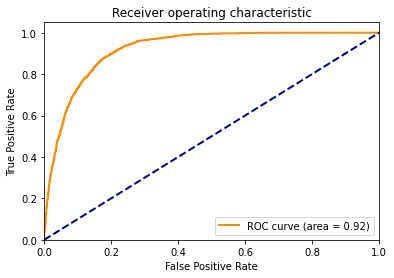

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

val_predictions = test(model, val_df, device)
val_targets = val_df['is_duplicate'].values

#FPR,TPR, threshold values
fpr, tpr, thresholds = roc_curve(val_targets, val_predictions)

# area for ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
#checking similarity(confidence)
def eval(model, tokenizer, first_question, second_question, device):
    inputs = tokenizer.encode_plus(
        first_question,
        second_question,
        add_special_tokens=True,
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(device, dtype=torch.long)
    mask = torch.tensor([inputs["attention_mask"]], dtype=torch.long).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([inputs["token_type_ids"]], dtype=torch.long).to(device, dtype=torch.long)

    with torch.no_grad():
        model.eval()
        output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        prob = nn.Sigmoid()(output).item()

        print(prob)

In [28]:
# change questions to test model
first_question = "most fruits are vegetables"
second_question = "not all vegetables are fruits"

eval(model, tokenizer, first_question, second_question, device)

0.8338996767997742


In [ ]:
train_df.sample(30)